100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 160.94it/s]


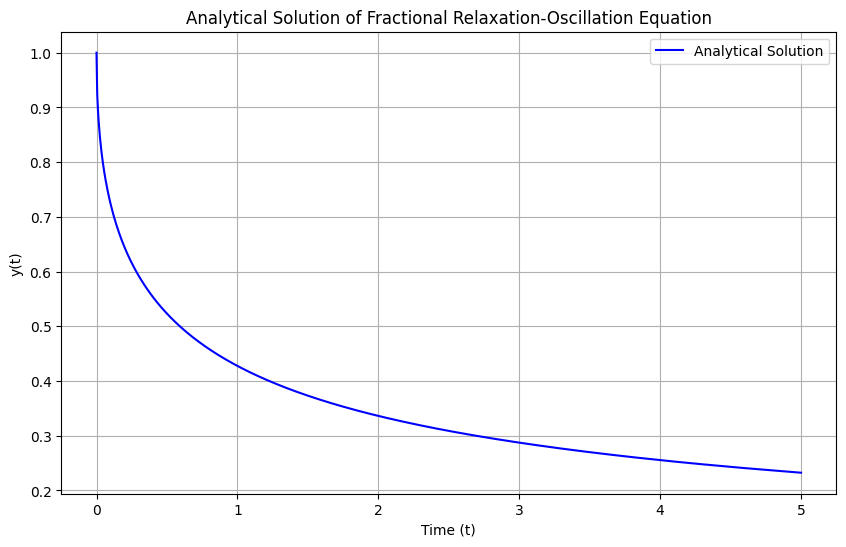

In [23]:
from jax.scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Parameters
lambda_param = 1.0  # decay rate
alpha = 0.5  # fractional order
y0 = 1.0  # initial condition

def mittag_leffler(z, alpha):
    # Mittag-Leffler function E_alpha(z)
    return np.sum((z**k) / (gamma(alpha * k + 1)) for k in range(100))

def analytical_solution(t):
    # Analytical solution y(t) = y0 * E_alpha(-lambda * t^alpha)
    return y0 * mittag_leffler(-lambda_param * t**alpha, alpha)

# Generate data for plotting
t_values = np.linspace(0, 5, 1000)
y_values = [analytical_solution(t) for t in tqdm(t_values)]

# Plotting
def plot_solution(t_values, y_values):
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, y_values, label='Analytical Solution', color='blue')
    plt.title('Analytical Solution of Fractional Relaxation-Oscillation Equation')
    plt.xlabel('Time (t)')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_solution(t_values, y_values)

In [41]:
from jax import vmap
from flax import linen as nn
from typing import Callable, List
from dataclasses import field
from jax.nn.initializers import normal

class FourierFeats(nn.Module):
    num_output: int
    embed_scale = 100
    
    @nn.compact
    def __call__(self, x):
        kernel = self.param(
            "kernel", normal(stddev=self.embed_scale), (x.shape[-1], self.num_output // 2)
        )
        y = jnp.concatenate(
            [jnp.cos(jnp.dot(x, kernel)), jnp.sin(jnp.dot(x, kernel))], axis=-1
        )
        return y
    
class GeneralizedMLP(nn.Module):
    kernel_init: Callable
    num_input: int
    num_output: int
    use_fourier_feats: bool = False  # Whether to use FourierFeats as the first layer
    layer_sizes: List[int] = field(default_factory=list)

    std = 10
    mean = 0

    @nn.compact
    def __call__(self, x):
        # Add hidden layers
        for idx, size in enumerate(self.layer_sizes):
            if self.use_fourier_feats and idx==0:
                x = FourierFeats(size)(x)
            else:
                x = nn.Dense(size, kernel_init=self.kernel_init)(x)
                x = nn.tanh(x)

        # Final output layer
        x = nn.Dense(self.num_output, kernel_init=self.kernel_init)(x)
        return x

model = GeneralizedMLP(
    kernel_init=nn.initializers.glorot_normal(),
    num_input=1,
    num_output=1,
    use_fourier_feats=True,
    layer_sizes=[256, 256, 256],
)

key = jax.random.PRNGKey(0)
collocs = jnp.ones((1))
params = model.init(key, collocs)['params']
model.apply({"params": params}, collocs)

Array([-0.23367916], dtype=float32)

In [49]:
@jax.jit
def inference(params, t):
    output = model.apply({'params': params}, jnp.array([t]))
    return output[0]

def get_caputo_derivative(inference, alpha):
    @jax.jit
    def caputo_derivative(params, t, num_steps=50):
        grad_inference = grad(inference, 1)
        
        def integrand(tau):
            return grad_inference(params, tau) / (t - tau)**alpha
        
        # Compute tau values for integration
        tau_values = jnp.linspace(0, t, num_steps, endpoint=False)  # Exclude t
        integrand_values = vmap(integrand)(tau_values)
        
        integral = jnp.trapezoid(integrand_values, tau_values)
    
        return integral / gamma(1 - alpha)
    
    return caputo_derivative

print(inference(params, 0.))

-0.57544994


In [108]:
from functools import partial

class relaxation_oscillation():
    def __init__(self, model, u0, alpha=.5, lambda_param=1):
        self.model = model
        self.u0 = u0
        self.caputo = get_caputo_derivative(inference, alpha)
        self.lambda_param = lambda_param
    
    @partial(jit, static_argnums=(0,))
    def predict(self, params, t):
        output = model.apply({'params': params}, jnp.array([t]))
        return output[0]
    
    @partial(jit, static_argnums=(0,))
    def res_loss(self, params, t):
        dalpha_t = self.caputo(params, t)
        u_t = self.predict(params, t)
        return dalpha_t + self.lambda_param*u_t

    @partial(jit, static_argnums=(0,))
    def losses(self, params, collocs):
        residuals = jax.vmap(self.res_loss, (None, 0))(params, collocs)
        
        ic_loss = (self.predict(params, 0.) - self.u0) ** 2
        res_loss =jnp.sum(residuals**2)

        loss_dict = {
            'ic_loss': ic_loss,
            'res_loss': res_loss,
        }
        
        return loss_dict

    @partial(jit, static_argnums=(0,))
    def loss(self, params, collocs):
        loss_dict = self.losses(params, collocs)
        loss = loss_dict['ic_loss'] + 1e-6*loss_dict['res_loss']
        # print(loss_dict['ic_loss'],1e-6*loss_dict['res_loss'])
        return loss, loss_dict

u0 = 1
rel_osc = relaxation_oscillation(model, u0)
rel_osc.predict(params, 0.)
rel_osc.res_loss(params, .1)

Array(2.1603546, dtype=float32)

In [110]:
# Define your gradient function
grad_fn = jax.jit(jax.value_and_grad(jax.jit(rel_osc.loss), has_aux=True))

@jax.jit
def apply_updates(params, updates):
    return optax.apply_updates(params, updates)

@jax.jit
def train_step(params, collocs, opt_state):
    # Compute loss and gradients
    (loss, loss_dict), grads = grad_fn(params, collocs)

    # Apply gradients to update the parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = apply_updates(params, updates)
        
    return params, opt_state, loss, loss_dict

In [111]:
import optax

schedule_fn = optax.exponential_decay(
    init_value=1e-4,       # Initial learning rate
    transition_steps=1000, # Decay steps
    decay_rate=0.5,        # Decay rate
    staircase=True         # Discrete decay steps
)

# Optimizer setup with Adam
optimizer = optax.adamw(
    learning_rate=schedule_fn,
    b1=0.9,     # Beta1
    b2=0.999,   # Beta2
    eps=1e-8    # Epsilon
)

opt_state = optimizer.init(params)

In [117]:
EPOCHS = 200

key = jax.random.PRNGKey(0)
BS = 1024

for i in (pbar := tqdm(range(0, EPOCHS))):
    key , _ = jax.random.split(key)
    collocs = jax.random.uniform(key=key,shape=(BS), minval=0, maxval=5)
    
    params, opt_state, loss, loss_dict = train_step(params, collocs, opt_state)
    
    if i % 100 == 0:
        pbar.set_description(f"Loss {loss: .8f}")
        print(loss_dict)

Loss  0.01290128:   0%|▏                        | 1/200 [00:00<03:07,  1.06it/s]

{'ic_loss': Array(2.0807678e-05, dtype=float32), 'res_loss': Array(12880.469, dtype=float32)}


Loss  0.01290128:  38%|█████████▏              | 77/200 [00:52<01:24,  1.46it/s]


KeyboardInterrupt: 

In [118]:
preds = jax.vmap(rel_osc.predict, (None, 0))(params, t_values)
preds

Array([ 9.99668539e-01,  1.06018651e+00,  1.01318979e+00,  1.03314543e+00,
        1.09708381e+00,  1.15002072e+00,  1.01704025e+00,  8.29707146e-01,
        8.77921641e-01,  9.21794236e-01,  7.91720390e-01,  5.09176016e-01,
        3.58381778e-01,  3.46116692e-01,  3.84527832e-01,  2.47197092e-01,
        2.13135913e-01,  2.34103829e-01,  2.01142922e-01,  1.71754375e-01,
        1.87175840e-01,  9.30669084e-02,  1.11529581e-01,  2.27361798e-01,
        2.36929897e-02, -9.06322002e-02, -2.30683178e-01, -2.12060586e-01,
       -1.35207549e-01, -5.37696257e-02,  1.22048728e-01,  3.43321770e-01,
        3.92465383e-01,  3.88653696e-01,  3.17562699e-01,  3.65462542e-01,
        3.80709320e-01,  1.74832910e-01,  9.88078937e-02,  2.65539229e-01,
        3.05242091e-01,  1.81290761e-01, -3.46809551e-02, -1.27613276e-01,
       -8.38849917e-02, -1.66167527e-01, -2.10531652e-01, -1.84808046e-01,
       -1.96595266e-01, -9.72778276e-02, -4.20299470e-02,  6.15451261e-02,
        1.55300364e-01,  

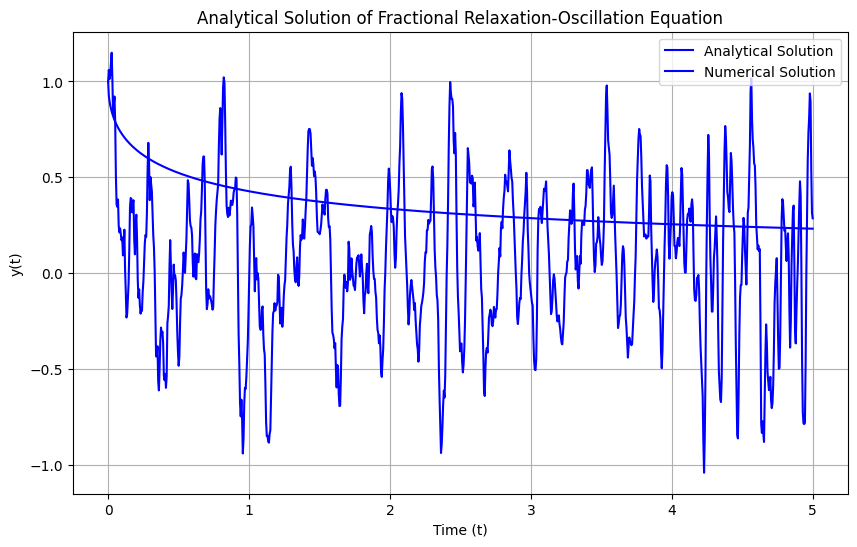

In [119]:
# Plotting
def plot_solution(t_values, y_values, y_preds):
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, y_values, label='Analytical Solution', color='blue')
    plt.plot(t_values, y_preds, label='Numerical Solution', color='blue')
    plt.title('Analytical Solution of Fractional Relaxation-Oscillation Equation')
    plt.xlabel('Time (t)')
    plt.ylabel('y(t)')
    plt.grid(True)
    plt.legend()
    plt.show()


plot_solution(t_values, y_values, preds)